# 英語で話しかける人のテキストを確認

In [1]:
text_en = ""
with open("./sample.txt") as f:
    for t in f.readlines():
        text_en += t
print(text_en)

I have to go to ABC Hotel by 5pm today.
But I'm at a loss because I don't know how to get to ABC Hotel.
I only have 30 minutes left, please tell me how to get there.



# 本日使うAWSサービスのクライアントインスタンスをまとめて生成

In [2]:
from datetime import datetime
from time import sleep
from pathlib import Path
import json
import boto3
from matplotlib import pyplot as plt

In [3]:
# 使用するboto3 clientインスタンス生成
polly_client = boto3.client("polly")
translate_client = boto3.client("translate")
s3_client = boto3.client("s3")
transcribe_client = boto3.client("transcribe")
comprehend_client = comprehend = boto3.client('comprehend')

# 英語で話す音声を Amazon Polly で作成する

In [4]:
# API 実行
polly_response = polly_client.synthesize_speech(
    OutputFormat='mp3', # 音声出力フォーマット
    LanguageCode='en-US', # 言語を指定
    Text=text_en, # 英語のテキストを指定
    VoiceId="Joanna" # Joannna,Mizuki,Takumiなど
)

In [5]:
# 音声ファイルを出力 (mp3)
mp3_binary = polly_response["AudioStream"].read()
file_name = "talk_en.mp3"
file_path = "./"
with open(file_path + file_name,"wb") as f:
    f.write(mp3_binary)

# Amazon Transcribeを使って音声ファイルを文字起こしする

* 英語で話されても理解できないため、まずは文字起こしを行う
* Amazon transcribe は文字起こしする対象のデータがS3に保存されている必要があるため、先程作成したmp3ファイルをS3に配置する。
* 配置したS3のURIを指定して Transcribe のジョブを作成する

In [6]:
# 事前にS3のバケットを用意
# 音声ファイルを配置するバケット名は input_bucket_name に、文字起こし結果を格納するバケット名はoutput_bucket_nameに格納する
input_bucket_name = "transcribe-input-bucket-202004161130"
output_bucket_name = "transcribe-output-bucket-202004161130"

In [7]:
# mp3をS3へアップロード
s3_client.upload_file(file_path + file_name, input_bucket_name, file_name)
print("s3://" + input_bucket_name + "/" + file_name)

s3://transcribe-input-bucket-202004161130/talk_en.mp3


In [8]:
# transcribe API実行
file_uri = f's3://{input_bucket_name}/{file_name}'
# job_nameはファイル名から拡張子を除去した上( talk_en )、年月日時刻を設定
job_name = Path(file_name).stem + datetime.now().strftime('%Y%m%d%H%M%S')
transcribe_response = transcribe_client.start_transcription_job(
    TranscriptionJobName=job_name,
    Media={
        'MediaFileUri':file_uri
    },
    MediaFormat='mp3',
    LanguageCode='en-US',
    OutputBucketName= output_bucket_name
)

In [9]:
s3_response = s3_client.get_object(Bucket=output_bucket_name,Key=job_name+".json")['Body'].read()
transcribe_data = json.loads(s3_response)["results"]["transcripts"][0]["transcript"]
print(transcribe_data)

I have to go to ABC Hotel by 5 p.m. Today. But I'm at a loss because I don't know how to get to ABC Hotel. I only have 30 minutes left. Please tell me how to get there.


In [10]:
print(transcribe_data.replace(".",""))
print(text_en.replace("\n"," ").replace(".","").replace(",",""))

I have to go to ABC Hotel by 5 pm Today But I'm at a loss because I don't know how to get to ABC Hotel I only have 30 minutes left Please tell me how to get there
I have to go to ABC Hotel by 5pm today But I'm at a loss because I don't know how to get to ABC Hotel I only have 30 minutes left please tell me how to get there 


# 文字起こししたデータを日本語に翻訳

In [11]:
translate_response = translate_client.translate_text(
    Text=transcribe_data, # 翻訳したい文字列を指定
    SourceLanguageCode="en", # 翻訳「元」の言語
    TargetLanguageCode="ja" # 翻訳「先」の言語
)
text_jp = translate_response["TranslatedText"]
print(text_jp)

今日は午後5時までにABCホテルに行かなきゃでもABCホテルへの行き方が分からんから途方に暮れてる30分しか残ってない行き方を教えてください。


# Comprehend でエンティティの抽出

In [12]:
# detect_entities でエンティティを抽出
response_entities = comprehend_client.detect_entities(Text=text_jp, LanguageCode="ja")
for entity in response_entities["Entities"]:
    print(entity)

{'Score': 0.868171751499176, 'Type': 'DATE', 'Text': '今日', 'BeginOffset': 0, 'EndOffset': 2}
{'Score': 0.9926034808158875, 'Type': 'DATE', 'Text': '午後5時', 'BeginOffset': 3, 'EndOffset': 7}
{'Score': 0.9786354899406433, 'Type': 'ORGANIZATION', 'Text': 'ABCホテル', 'BeginOffset': 10, 'EndOffset': 16}
{'Score': 0.9924710392951965, 'Type': 'ORGANIZATION', 'Text': 'ABCホテル', 'BeginOffset': 24, 'EndOffset': 30}
{'Score': 0.99479740858078, 'Type': 'QUANTITY', 'Text': '30分', 'BeginOffset': 49, 'EndOffset': 52}


# Comprehend でキーフレーズの抽出

In [13]:
# detect_key_phrases でキーフレーズの抽出
response_key_phrases = comprehend_client.detect_key_phrases(Text=text_jp, LanguageCode="ja")
for key_phrase in response_key_phrases["KeyPhrases"]:
    print(key_phrase)

{'Score': 0.999996542930603, 'Text': '今日', 'BeginOffset': 0, 'EndOffset': 2}
{'Score': 0.9999988675117493, 'Text': '午後5時', 'BeginOffset': 3, 'EndOffset': 7}
{'Score': 0.9999999403953552, 'Text': 'ABCホテル', 'BeginOffset': 10, 'EndOffset': 16}
{'Score': 0.9999346733093262, 'Text': 'ABCホテルへの行き方', 'BeginOffset': 24, 'EndOffset': 35}
{'Score': 0.9999992847442627, 'Text': '途方', 'BeginOffset': 42, 'EndOffset': 44}
{'Score': 0.9999986290931702, 'Text': '30分', 'BeginOffset': 49, 'EndOffset': 52}
{'Score': 0.9999966621398926, 'Text': '行き方', 'BeginOffset': 59, 'EndOffset': 62}


# Comprehendで感情の検出

In [14]:
# detect_sentiment で感情を検出
response_sentiment = comprehend_client.detect_sentiment(Text=text_jp, LanguageCode="ja")
print(response_sentiment["Sentiment"])
print(response_sentiment["SentimentScore"])

NEUTRAL
{'Positive': 0.0004968263674527407, 'Negative': 0.12053017318248749, 'Neutral': 0.8789694309234619, 'Mixed': 3.5541199849831173e-06}


# 感情を少し見やすく棒グラフで

<BarContainer object of 4 artists>

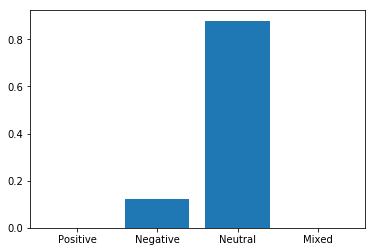

In [15]:
x_axis = []
sentiment_score = []
for sentiment in response_sentiment["SentimentScore"].keys():
    x_axis.append(sentiment)
    sentiment_score.append(response_sentiment["SentimentScore"][sentiment])

plt.bar(x_axis, sentiment_score, tick_label=x_axis, align="center")

In [16]:
print(text_jp)

今日は午後5時までにABCホテルに行かなきゃでもABCホテルへの行き方が分からんから途方に暮れてる30分しか残ってない行き方を教えてください。


In [ ]:
import boto3
client = boto3.client('transcribe')

In [ ]:
for job in client.list_transcription_jobs()["TranscriptionJobSummaries"]:
    jobname = job["TranscriptionJobName"]
    client.delete_transcription_job(TranscriptionJobName=jobname) 

In [ ]:
client.list_transcription_jobs()["TranscriptionJobSummaries"]